# Imports

In [1]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Constants + Helper Functions

In [2]:
CONJUNCTION_COLORS = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

LIKE_UNLIKE_COLORS = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

CATEGORY_COLORS = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

CONJUNCTIONS = ['and', 'or', 'but', 'nor']

In [3]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [4]:
def get_wordnet_dfs(df):
    '''
    Get five DataFrames for each WordNet relation (synonymy, antonymy,
    hypernymy, co-hyponymy, entailment) using examples from the given
    input df.

    @param df (DataFrame): input of raw coordination samples
    @return (5-tuple of DataFrames): tuple containing a DataFrame for each
        WordNet relation (synonymy_df, antonymy_df, hypernymy_df,
        cohyponymy_df, entailment_df)
    '''
    
    # Get like coordinations
    likes = utils.likes_df(df)

    # Finding closures over wordnet relations produces redundant search warnings
    # We'll just filter these warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Get wordnet relations for like coordinations
        synonymy_df = utils.analyze_synonymy(likes)
        antonymy_df = utils.analyze_antonymy(likes)
        hypernymy_df = utils.analyze_hypernymy(likes)
        cohyponymy_df = utils.analyze_cohyponymy(likes)
        entailment_df = utils.analyze_entailment(likes)

    return (synonymy_df, antonymy_df, hypernymy_df, cohyponymy_df, entailment_df)

# Load Data and Get WordNet Relations

In [5]:
# GUM
gum_samples = get_df_from_path('csv/GUM/*.csv')
gum_synonymy_df, gum_antonymy_df, gum_hypernymy_df, gum_cohyponymy_df, gum_entailment_df \
    = get_wordnet_dfs(gum_samples)

# EWT
ewt_samples = get_df_from_path('csv/EWT/*.csv')
ewt_synonymy_df, ewt_antonymy_df, ewt_hypernymy_df, ewt_cohyponymy_df, ewt_entailment_df \
    = get_wordnet_dfs(ewt_samples)

# PUD
pud_samples = get_df_from_path('csv/PUD/*.csv')
pud_synonymy_df, pud_antonymy_df, pud_hypernymy_df, pud_cohyponymy_df, pud_entailment_df \
    = get_wordnet_dfs(pud_samples)

# All sources
all_synonymy_df = pd.concat(
    [gum_synonymy_df, ewt_synonymy_df, pud_synonymy_df], axis=0, ignore_index=True)
all_antonymy_df = pd.concat(
    [gum_antonymy_df, ewt_antonymy_df, pud_antonymy_df], axis=0, ignore_index=True)
all_hypernymy_df = pd.concat(
    [gum_hypernymy_df, ewt_hypernymy_df, pud_hypernymy_df], axis=0, ignore_index=True)
all_cohyponymy_df = pd.concat(
    [gum_cohyponymy_df, ewt_cohyponymy_df, pud_cohyponymy_df], axis=0, ignore_index=True)
all_entailment_df = pd.concat(
    [gum_entailment_df, ewt_entailment_df, pud_entailment_df], axis=0, ignore_index=True)

utils.pretty_print(all_synonymy_df[all_synonymy_df['Synonyms?']], 'rtf/synonyms.rtf')
utils.pretty_print(all_antonymy_df[all_antonymy_df['Antonyms?']], 'rtf/antonyms.rtf')


# Synonymy and Antonymy

In [6]:
def distribution_by_conjunction(relation_df, freq_func, relation_title, outfile, source=None):

    if source is not None:
        print(source)
    else:
        print('All Data')
    print()

    labels = []
    freqs = []

    for conjunction in CONJUNCTIONS:
        print(conjunction)

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freqs.append(freq_func(df))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, freqs, width, color=CONJUNCTION_COLORS.values())

    if source is not None:
        title = 'Percentages of Coordinations with {}\nby Conjunction ({})'.format(
            relation_title, source)
    else:
        title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
            relation_title)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    print()

    plt.savefig(outfile, bbox_inches='tight')


def distribution_by_category(relation_df, freq_func, relation_title, outfile, source=None):

    if source is not None:
        print(source)
    else:
        print('All Data')
    print()

    labels = []
    syns_freqs = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    print('Nominal')
    labels.append('Nominal')
    syns_freqs.append(freq_func(nouns))

    print('Verbal')
    labels.append('Verbal')
    syns_freqs.append(freq_func(verbs))

    print('Adjectival')
    labels.append('Adjectival')
    syns_freqs.append(freq_func(adjps))

    print('Adverbial')
    labels.append('Adverbial')
    syns_freqs.append(freq_func(advps))

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, syns_freqs, width, color=CATEGORY_COLORS.values())

    if source is not None:
        title = 'Percentages of Coordinations with {}\nby Syntactic Category ({})'.format(
            relation_title, source)
    else:
        title = 'Percentages of Coordinations with {}\nby Syntactic Category'.format(
            relation_title)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    print()
    
    plt.savefig(outfile, bbox_inches='tight')


## Synonymy

In [7]:
def get_synonyms_freqs(df):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    print('syns:', syns_count)
    print('not syns:', tot - syns_count)

    return syns_count / tot if tot != 0 else 0

### By Conjunction

All Data

and
syns: 163
not syns: 5424
or
syns: 23
not syns: 681
but
syns: 18
not syns: 611
nor
syns: 1
not syns: 16

GUM

and
syns: 45
not syns: 2053
or
syns: 9
not syns: 308
but
syns: 6
not syns: 232
nor
syns: 1
not syns: 7

EWT

and
syns: 114
not syns: 3124
or
syns: 13
not syns: 358
but
syns: 12
not syns: 349
nor
syns: 0
not syns: 9

PUD

and
syns: 4
not syns: 247
or
syns: 1
not syns: 15
but
syns: 0
not syns: 30
nor
syns: 0
not syns: 0



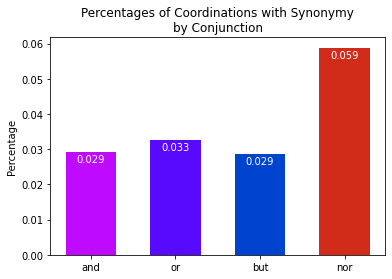

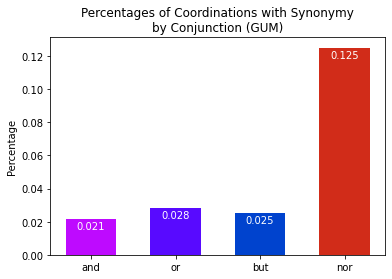

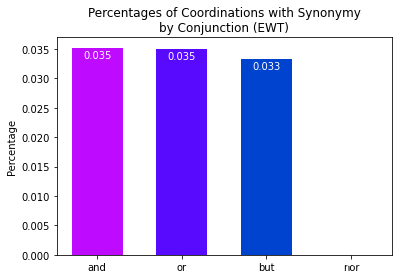

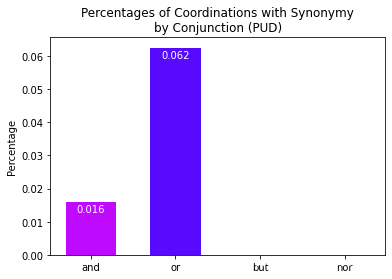

In [8]:
def synonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_synonyms_freqs, "Synonymy", outfile, source)

synonym_conjunction_distribution(all_synonymy_df, 'charts/synonymy_by_conjunction.pdf')
synonym_conjunction_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_conjunction.pdf', source='GUM')
synonym_conjunction_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_conjunction.pdf', source='EWT')
synonym_conjunction_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_conjunction.pdf', source='PUD')

### By Category

All Data

Nominal
syns: 38
not syns: 2439
Verbal
syns: 150
not syns: 3563
Adjectival
syns: 15
not syns: 625
Adverbial
syns: 2
not syns: 105

GUM

Nominal
syns: 13
not syns: 985
Verbal
syns: 41
not syns: 1326
Adjectival
syns: 6
not syns: 242
Adverbial
syns: 1
not syns: 47

EWT

Nominal
syns: 24
not syns: 1333
Verbal
syns: 107
not syns: 2084
Adjectival
syns: 8
not syns: 366
Adverbial
syns: 0
not syns: 57

PUD

Nominal
syns: 1
not syns: 121
Verbal
syns: 2
not syns: 153
Adjectival
syns: 1
not syns: 17
Adverbial
syns: 1
not syns: 1



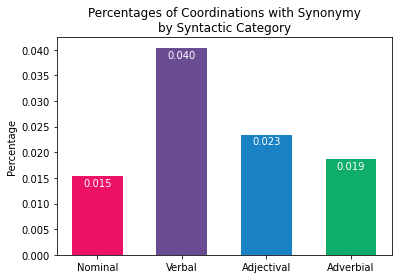

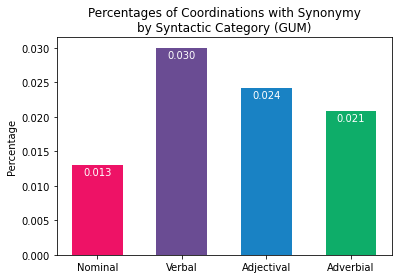

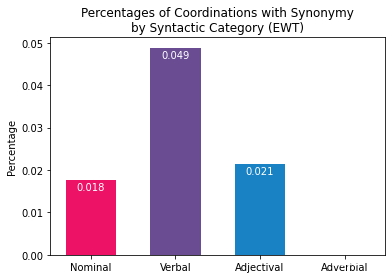

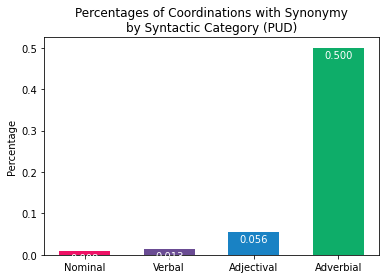

In [9]:
def synonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_synonyms_freqs, "Synonymy", outfile, source)

synonym_category_distribution(all_synonymy_df, 'charts/synonymy_by_category.pdf')
synonym_category_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_category.pdf', source='GUM')
synonym_category_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_category.pdf', source='EWT')
synonym_category_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_category.pdf', source='PUD')

## Antonymy

In [10]:
def get_antonyms_freqs(df):
    # Get antonyms
    ants = df.loc[(df['Antonyms?'] == True)]
    ants.reset_index(drop=True, inplace=True)

    # Get counts
    count_ants = len(ants.index)
    tot = len(df.index)

    print('ants:', count_ants)
    print('not ants:', tot - count_ants)

    return count_ants / tot if tot != 0 else 0


### By Conjunction

All Data

and
ants: 38
not ants: 567
or
ants: 13
not ants: 51
but
ants: 1
not ants: 52
nor
ants: 0
not ants: 1

GUM

and
ants: 24
not ants: 201
or
ants: 5
not ants: 25
but
ants: 0
not ants: 17
nor
ants: 0
not ants: 0

EWT

and
ants: 13
not ants: 348
or
ants: 8
not ants: 26
but
ants: 1
not ants: 34
nor
ants: 0
not ants: 1

PUD

and
ants: 1
not ants: 18
or
ants: 0
not ants: 0
but
ants: 0
not ants: 1
nor
ants: 0
not ants: 0



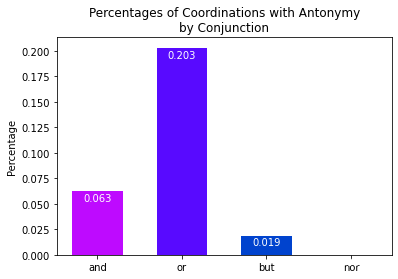

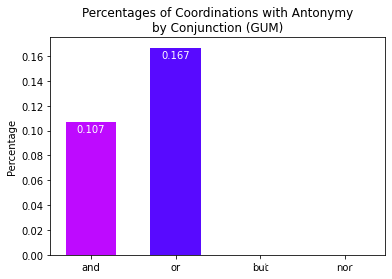

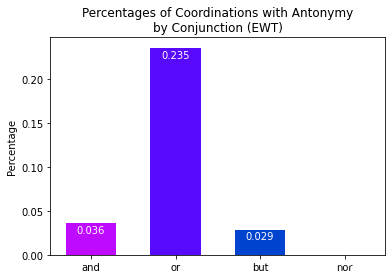

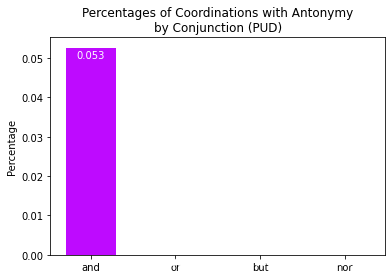

In [11]:
def antonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_antonyms_freqs, "Antonymy", outfile, source)

antonym_conjunction_distribution(all_antonymy_df, 'charts/antonymy_by_conjunction.pdf')
antonym_conjunction_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_conjunction.pdf', source='GUM')
antonym_conjunction_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_conjunction.pdf', source='EWT')
antonym_conjunction_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_conjunction.pdf', source='PUD')

### By Category

All Data

Nominal
ants: 0
not ants: 0
Verbal
ants: 0
not ants: 0
Adjectival
ants: 37
not ants: 583
Adverbial
ants: 15
not ants: 88

GUM

Nominal
ants: 0
not ants: 0
Verbal
ants: 0
not ants: 0
Adjectival
ants: 19
not ants: 209
Adverbial
ants: 10
not ants: 34

EWT

Nominal
ants: 0
not ants: 0
Verbal
ants: 0
not ants: 0
Adjectival
ants: 17
not ants: 357
Adverbial
ants: 5
not ants: 52

PUD

Nominal
ants: 0
not ants: 0
Verbal
ants: 0
not ants: 0
Adjectival
ants: 1
not ants: 17
Adverbial
ants: 0
not ants: 2



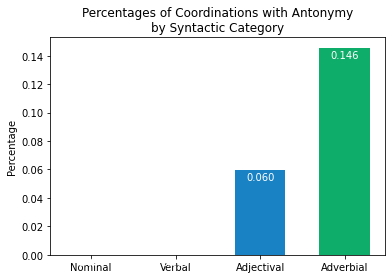

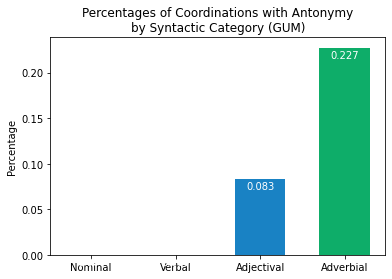

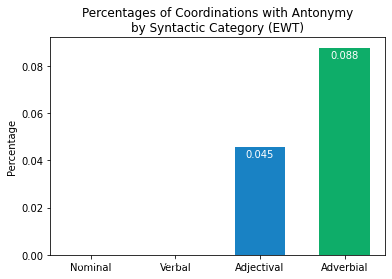

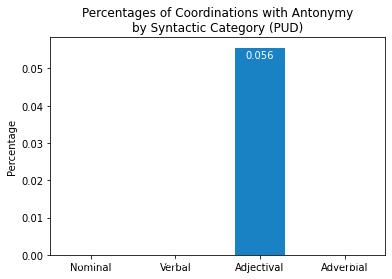

In [12]:
def antonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_antonyms_freqs, "Antonymy", outfile, source)

antonym_category_distribution(all_antonymy_df, 'charts/antonymy_by_category.pdf')
antonym_category_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_category.pdf', source='GUM')
antonym_category_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_category.pdf', source='EWT')
antonym_category_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_category.pdf', source='PUD')

# Hypernymy

In [26]:
def get_hypernymy_freqs(df):
    tot = len(df.index)
    df = df.loc[(df['1st Conjunct Hypernym?'] == True) | (df['2nd Conjunct Hypernym?'] == True)]
    df = df.loc[(df['1st Conjunct Hypernym?']) != (df['2nd Conjunct Hypernym?'])]

    # Get 1st conjunct hypernymy
    hyps1 = df.loc[(df['1st Conjunct Hypernym?'] == True)]
    hyps1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct hypernymy
    hyps2 = df.loc[(df['2nd Conjunct Hypernym?'] == True)]
    hyps2.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps1 = len(hyps1.index)
    count_hyps2 = len(hyps2.index)

    print('hyps1:', count_hyps1)
    print('hyps2:', count_hyps2)
    
    return (count_hyps1 / tot, count_hyps2 / tot) if tot != 0 else (0,0)

In [29]:
def hypernymy_by_conjunction(hypernymy_df, outfile, source=None):
    labels = []
    hyps1_freqs = []
    hyps2_freqs = []

    if source is not None:
        print(source)
    else:
        print('All Data')
    print()

    for conjunction in ['and','or','but']:
        print(conjunction)

        labels.append(conjunction)

        df = hypernymy_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        hyps1_freq, hyps2_freq = get_hypernymy_freqs(df)
        hyps1_freqs.append(hyps1_freq)
        hyps2_freqs.append(hyps2_freq)

        print()

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, hyps1_freqs, width,
                    label='First Conjunct Hypernym')
    rects2 = ax.bar(x + width/2, hyps2_freqs, width,
                    label='Second Conjunct Hypernym')

    if source is None:
        title = 'Percentages of Coordinations with Hypernymy\nby Conjunction'
    else:
        title = 'Percentages of Coordinations with Hypernymy\nby Conjunction ({})'.format(
            source)
    print()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage of Coordinations with Hypernymy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.savefig(outfile, bbox_inches='tight')


All Data

and
hyps1: 277
hyps2: 301

or
hyps1: 37
hyps2: 49

but
hyps1: 42
hyps2: 36


GUM

and
hyps1: 87
hyps2: 95

or
hyps1: 14
hyps2: 22

but
hyps1: 8
hyps2: 14


EWT

and
hyps1: 183
hyps2: 194

or
hyps1: 22
hyps2: 27

but
hyps1: 32
hyps2: 21


PUD

and
hyps1: 7
hyps2: 12

or
hyps1: 1
hyps2: 0

but
hyps1: 2
hyps2: 1




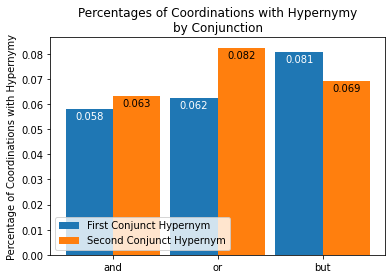

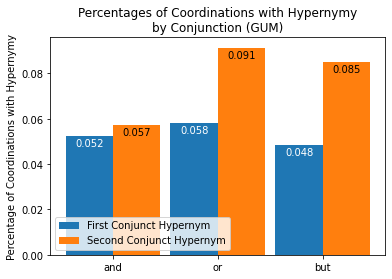

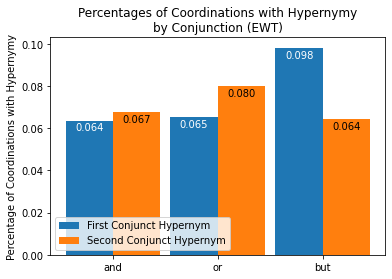

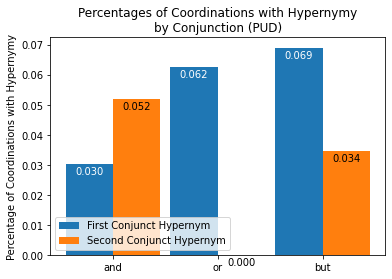

In [30]:
hypernymy_by_conjunction(all_hypernymy_df, 'charts/hypernymy_by_category.pdf')
hypernymy_by_conjunction(gum_hypernymy_df, 'charts/GUM_hypernymy_by_category.pdf', source='GUM')
hypernymy_by_conjunction(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_category.pdf', source='EWT')
hypernymy_by_conjunction(pud_hypernymy_df, 'charts/PUD_hypernymy_by_category.pdf', source='PUD')